In [1]:
%load_ext autoreload
%autoreload 2

#per la riproducibilità
%env CUBLAS_WORKSPACE_CONFIG=":4096:8"

import os
import itertools
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from IPython.display import Markdown as md
from multiprocessing import Pool
import time
from tqdm import tqdm
import networkx as nx
from networkx import stochastic_block_model


from graph_generation import GenerateGraph, perturb_nx_graph
from models import GCN, view_parameters, new_parameters, modify_parameters, Inits, new_parameters_linears
from train import Trainer, Dataset
from embedding import Embedding
from config_valid import Config, TrainingMode
import experiments
from experiments import Experiments, all_seeds
from plot_funcs import (plot_dim1, plot_dimN, plot_correlation_error, plot_metrics, plot_node_emb_1D, plot_node_emb_nD, scatter_node_emb, 
                        plot_graph_emb_1D, plot_graph_emb_nD, plot_data_degree_sequence, plot_corr_epoch, plot_ripetizioni_stesso_trial, 
                        plot_onlyloss_ripetizioni_stesso_trial,plot_onlyloss_ripetizioni_stesso_trial_superimposed, Data2Plot, plot_weights_multiple_hist)
from plot_model import plot_model
from utils import array_wo_outliers, plot_grafo, plot_grafo2
from Inspect import Inspect


import torch
from torch_geometric import nn
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

from scipy import stats
from sklearn.metrics import log_loss

import pickle 
from plt_parameters import init_params, get_colors_to_cycle_rainbow8, get_colors_to_cycle_rainbowN
init_params()
rootsave = Path("output_plots/")

def make_video_parallel_static():
    experiments.graph_embedding_per_epoch = xp.trainer.graph_embedding_per_epoch
    experiments.node_embedding_per_epoch = xp.trainer.node_embedding_per_epoch
    experiments.dataset = xp.trainer.dataset
    experiments.loss_list = xp.trainer.test_loss_list
    experiments.exp_config = xp.trainer.config_class
    experiments.dataset_type = xp.trainer.gg.graphtype
    num_emb_neurons = xp.trainer.model.convs[-1].out_channels
    experiments.trainmode = xp.trainer.config_class.modo
    #experiments.num_classes = xp.trainer.config_class.num_classes
    experiments.embedding_dimension = num_emb_neurons
    #my_list = my_log_lista=list(range(20)) + list(range(20,100,4)) + list(range(100,500, 15)) + list(range(500, 5000, 40))
    nomefile = xp.make_video(skip=1, fromfiles=True, custom_list=True, seq_colors=True)
    return nomefile


def run_grid_w_gif(xp):
    nomifilesgif = []
    k = 0
    for c in xp.gc.configs:  
        print(f'Run {k + 1}\t\t exp name: {c.unique_train_name}')
        # all_seeds()
        xp.trainer.reinit_conf(c)
        xp.just_train()
        embedding_class = xp.embedding()
        num_emb_neurons = xp.trainer.model.convs[-1].out_channels
        trainmode = xp.trainer.config_class.modo
        embedding_class.get_metrics(num_emb_neurons, trainmode)    
        nomefile = make_video_parallel_static()
        nomifilesgif.append(nomefile)
        k += 1
    return nomifilesgif

env: CUBLAS_WORKSPACE_CONFIG=":4096:8"


In [4]:
config_file = "configurations/Final1.yml"
num_nodi = 450
c = Config(config_file)
#c.conf['graph_dataset']['list_exponents'] = [-1.9, -2.5]
c.conf['model']['autoencoder'] = True
diz_trials = {'graph_dataset.ERmodel': [False], 'graph_dataset.confmodel': [True], 'graph_dataset.sbm': [False],
              'graph_dataset.Num_nodes': [num_nodi, [num_nodi]*6, [num_nodi]*2],  # per lo SBM: num nodi * num comunità 
              'model.GCNneurons_per_layer': [[1, 32, 16, len(c.conf['graph_dataset']['list_exponents'])],
                                            [1, 32, 16, len(c.conf['graph_dataset']['list_p'])],
                                            [1, 32, 16, len(c.conf['graph_dataset']['community_probs'])],
                                           ],
             'model.init_weights': ['xavier_normal'],# 'eye'],
             'model.freezeGCNlayers': [False],
             'model.last_layer_dense': [False],
             } 

xp = Experiments(config_file, diz_trials=diz_trials, rootsave=rootsave, config_class=c)

Autoencoder model
8 configurazioni saltate su 9, farò i seguenti 1 training:
GraphType.CM_Classi6_nodi450_grafiXtipo300_mode1_layers§1-32-16-6§_initw-xavier_normal_lr0.001_GCNfreezedFalse


In [ ]:
xp.GS_simple_experiments()

Run 1 		 exp name: GraphType.CM_Classi6_nodi450_grafiXtipo300_mode1_layers§1-32-16-6§_initw-xavier_normal_lr0.001_GCNfreezedFalse
Generating dataset...


Plotting 2D or n>=2 embeddings...


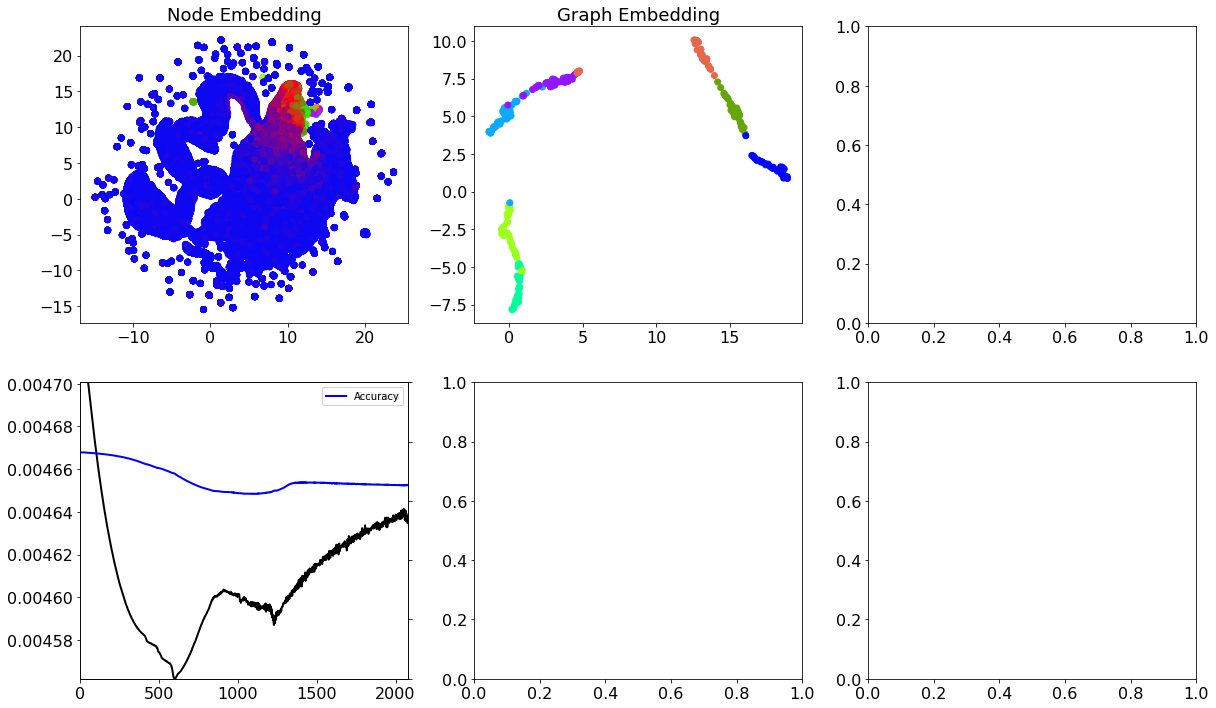

In [7]:
embedding_class = xp.embedding()

embedding_dimension = xp.trainer.model.convs[-1].out_channels
trainmode = xp.trainer.config_class.modo
dataset = xp.trainer.dataset
exp_config = xp.trainer.config_class


plot_metrics(embedding_class, embedding_dimension, trainmode, xp.trainer.test_loss_list, xp.trainer.metric_list,             
             sequential_colors=False, log=False)

In [3]:
run_grid_w_gif(xp)

Run 1		 exp name: GraphType.CM_Classi7_nodi450_grafiXtipo40_mode1_layers§1-32-7§_initw-xavier_normal_lr0.001_GCNfreezedFalse
Generating dataset...
Dataset generated
Loading Dataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:07<00:00, 38.68it/s]


Tempo impiegato: 7.244441270828247


 37%|█████████████████████████████████████                                                              | 3739/10000 [38:31<1:04:30,  1.62it/s]


KeyboardInterrupt: 

In [ ]:
embedding_class = xp.embedding()
num_emb_neurons = xp.trainer.model.convs[-1].out_channels
trainmode = xp.trainer.config_class.modo
embedding_class.get_metrics(num_emb_neurons, trainmode)    
nomefile = make_video_parallel_static()
nomifilesgif.append(nomefile)

# Come funziona il dataset per l'autoencoder -> split delle edges per la reconstruction

##### old method

In [12]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import train_test_split_edges
dataset = Planetoid("\..", "CiteSeer", transform=T.NormalizeFeatures())
data = dataset[0]
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)

/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [13]:
data

Data(x=[3327, 3703], val_pos_edge_index=[2, 227], test_pos_edge_index=[2, 455], train_pos_edge_index=[2, 7740], train_neg_adj_mask=[3327, 3327], val_neg_edge_index=[2, 227], test_neg_edge_index=[2, 455])

##### new method random link split

In [17]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
])
dataset = Planetoid("\..", "CiteSeer", transform=transform)
train_data, val_data, test_data = dataset[0]

In [18]:
train_data  # train data non ha le neg edges di default

Data(x=[3327, 3703], edge_index=[2, 7740], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], pos_edge_label=[3870], pos_edge_label_index=[2, 3870])

In [19]:
val_data  # val data ha le ned edges di default

Data(x=[3327, 3703], edge_index=[2, 7740], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327], pos_edge_label=[227], pos_edge_label_index=[2, 227], neg_edge_label=[227], neg_edge_label_index=[2, 227])

In [4]:
test_data

NameError: name 'test_data' is not defined

In [23]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)
    if args.variational:
        loss = loss + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)


for epoch in range(1, args.epochs + 1):
    loss = train()     
    auc, ap = test(test_data)
    # un problema con le diverse chiamate di test è non poter combinare le auc ...

NameError: name 'args' is not defined

### Split alternativo con il dataloader

In [ ]:
train:  pos_edge_label, pos_edge_label_index
test:   pos_edge_label, pos_edge_label_index, neg_edge_label, neg_edge_label_index

In [ ]:
edge_index_train = data.edge_index[:, train_mask]
edge_attr_train = data.edge_index[train_mask]